# Greedy Randomised Adaptive Search Procedure - **GRASP**
## Notes

For simplicity, all examples in this notebook are applied to the Symmetric TSP.  A nice extension would either by the basic VRP or TSP with time windows.

Implementations included in the notebook:
* **Basic (PURE) GRASP** Fixed RCL size + Hill Climbing (First Improvement) local search (with 2Opt Tweaks).
    * Illustration of the value of adding local search.
    * Variation 1: **Short term memory/tabu list** for constructor.
    * Variation 2: **Probablistic selection of RCL size.**
    * Variation 3: **Reactive GRASP.**
    * Variation 4: **Random Plus Greedy**
    * **Pick and Mix**
* **GRASP with Path Relinking (PR)**
    * **Elite Sets**
        * Example function implementing long term memory aiming to max performance and diversity of the set.
    * **Forward and backward path relinking** for the TSP
        * Example functions for implementing TSP path relinking in a restricted neighbourhood.
    * **Basic GRASP + PR**
    * Variation 1: **GRASP + Evolutionary PR**
    
* **Experiments**
    * 10 runs of each variation of GRASP to compare average and distribution of performance.  

> **Notes**: A bit of the metapy frameworks including `HillClimber` needs refactoring to make switching between max/min problems simpler.  It works here no problem, but is confusing if you look at the code compared to what has been done with GRASP (which is simpler)!

## Imports

In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from itertools import combinations

from joblib import Parallel, delayed

from decimal import Decimal, ROUND_HALF_UP

In [2]:
import metapy.tsp.tsp_io as io
import metapy.tsp.euclidean as e
from metapy.tsp.objective import SimpleTSPObjective, OptimisedSimpleTSPObjective
from metapy.local_search.hill_climbing import HillClimber, TweakTwoOpt

## Utility functions

* `gen_matrix()` - create travel distance matrix (truncate to int if reqiured.)
* `plot_tour()` - basic plot of a tour.

In [3]:
def gen_matrix(cities, as_integer=False):
    """
    Creates a numpy array of euclidian distances between 2 sets of
    cities
    
    Parameters:
    ----------
    points: numpy.array
        coordinate pairs
    
    as_integers: bool, optional (default=False)
        If true then round to nearest int
        Behaviour: 1.5 -> 2
                   1.2 -> 1
                   1.8 -> 2
                   
    Returns:
    -------
        np.ndarray
            Matrix of city to city costs
    
    """
    size = len(cities)
    matrix = np.zeros(shape=(size, size))
    
    row = 0
    col = 0
    
    for city1 in cities:
        col = 0
        for city2 in cities:
            distance = e.euclidean_distance(city1, city2)
            if as_integer:
                distance = int(Decimal(distance).quantize(0, ROUND_HALF_UP))
            matrix[row, col] = distance
            col+=1
        row +=1
        
    return matrix

In [4]:
def plot_tour(tour, cities, figsize=(6,4)):
    '''
    Plots a tour.  Each city visited is
    labelled in order.  Red point is the initial city.
    
    Params:
    ------
    tour: np.ndarray
        ordered vector representing tour e.g. [1, 4, 2, 3]
        
    cities: np.ndarray
        matrix representing city coordinates
        
    figsize: tuple, optional (default = (6,3))
        tuple of ints for figure size
        
    Returns
    -------
        tuple of matplotlib figure, and axis
    '''

    tour_length = len(tour)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    #plot points
    ax.plot(cities[:tour_length][:, 0],
            cities[:tour_length][:, 1],'bo')

    #plot lines
    for j in range(len(tour)-1):
        city_1 = tour[j]
        city_2 = tour[j+1]

        #lookup coordinates
        coords_1 = cities[city_1]
        coords_2 = cities[city_2]
        coords = np.vstack([coords_1, coords_2])

        #plot lines
        ax.plot(coords[:,0], coords[:,1], 'g-')
        
        #show order in tour
        ax.text(coords_1[0] + 0.8, coords_1[1] + 0.8, str(j))

    #add in loop back colour code in red...
    city_1 = tour[-1]
    city_2 = tour[0]

    coords_1 = cities[city_1]
    coords_2 = cities[city_2]
    coords = np.vstack([coords_1, coords_2])
    ax.text(coords_1[0] + 0.8, coords_1[1] + 0.8, str(tour_length-1))
    ax.plot(coords[:,0], coords[:,1], 'r--')
        
    return fig, ax

## Read in instance of the TSP and generate cost matrix

We will use the st70 dataset consisting of 70 cities.

In [5]:
#load file
file_path = "data/st70.tsp"

#number of rows in the file that are meta_data
md_rows = 6

#read the coordinates
cities = io.read_coordinates(file_path, md_rows)

#read the meta data
meta = io.read_meta_data(file_path, md_rows)

#should be an numpy.ndarray
print(type(cities))

# should be 70 cities
print(cities.shape)

#print first 2 coordinate pairs
print(cities[:2])

print("st70 meta data")
print(meta)

<class 'numpy.ndarray'>
(70, 2)
[[64. 96.]
 [80. 39.]]
st70 meta data
['NAME: st70', 'TYPE: TSP', 'COMMENT: 70-city problem (Smith/Thompson)', 'DIMENSION: 70', 'EDGE_WEIGHT_TYPE : EUC_2D']


In [6]:
#generate matrix
TRUNC = 70
trunc_cities = cities[:TRUNC]

matrix = gen_matrix(trunc_cities, as_integer=True)

file_out = 'data/st70_matrix.csv'

#output city matrix - to validate and use for manual calcs etc.
np.savetxt(file_out, matrix, delimiter=",")

In [7]:
#create ordered list of cities to visit
tour = np.arange(TRUNC)
tour

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])

## Ingredients for **Basic GRASP**

### Logic for the sizing of a Restricted Candidate List

This is handled by two classes: `FixedRCLSizer` and `RandomRCLSizer` that provide a constant and probabilitically selected size of the RCL, repectively


In [8]:
class FixedRCLSizer:
    '''
    Fixed sized RCL list
    '''
    def __init__(self, r):
        self.r = r
        
    def get_size(self):
        return self.r
    
class RandomRCLSizer:
    '''
    Probabilitic selection of the RCL size
    Uniform probability.
    '''
    def __init__(self, r_list, random_seed=None):
        self.r_list = r_list
        self.rng = np.random.default_rng(random_seed)
        
    def get_size(self, size=None):
        return self.rng.choice(self.r_list, size=size)

### Semi-Greedy Construction Heuristic

In [9]:
class SemiGreedyConstructor:
    '''
    Semi-greedy construction of a tour.
    
    For a city i creates a restricted candidate list of size r
    i.e the r shortest distances from city i.  Next city is chosen
    with equal probability.
    Repeats until tour is constructed.
    
    '''
    def __init__(self, rcl_sizer, tour, matrix,
                 random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        rcl_sizer: object
            sizes the restricted candidate list
        
        tour: np.ndarray
            vector of city indexes included in problem
            
        matrix: np.ndarray
            matrix of travel costs
            
        random_seed: int
            used to control sampling and provides a
            reproducible result.
        '''
        
        # size of rcl
        self.rcl_sizer = rcl_sizer
        
        # cities in a tour
        self.tour = tour
        
        # travel cost matrix
        self.matrix = matrix
        
        # create random number generator
        self.rng = np.random.default_rng(random_seed)
    
    def build(self):
        '''
        Semi-greedy contruction of tour
        
        Returns:
        --------
        np.array
        '''
        # first city in tour
        solution = np.array([self.tour[0]])    
        
        for i in range(len(self.tour)-1):
            r = self.rcl_sizer.get_size()
            rcl = self.get_rcl(r, solution, solution[-1])
            next_city = self.random_from_rcl(rcl)
            solution = np.append(solution, np.array([next_city]))
            
        return solution
    
    def get_rcl(self, r, solution, from_city):
        '''
        Restricted candidate list for final city in current solution
        
        Params:
        -------
        solution: np.ndarray
            vector of current partially constructed solution
            
        from_city: int
            index of city used to construct rcl.
        
        Returns:
        -------
        np.array
        '''
        # get indexes of cities not in solution
        mask = self.tour[~np.in1d(self.tour, solution)]
        
        # get indexes of r smallest travels costs 
        if mask.shape[0] > r:
            # partition the vector for remaining cities - faster than sorting 
            idx = np.argpartition(self.matrix[from_city][mask], len(mask) - r)[-r:]
            rcl = mask[idx]
        else:
            # handle when r < n cities remaining 
            rcl = mask
        return rcl
    
    def random_from_rcl(self, rcl):
        '''
        Select a city at random from rcl.
        Return city index in self.matrix
        
        Params:
        -------
        rcl: np.ndarray
            restricted candidate list
            vector of candidate city indexes.
        '''
        return self.rng.choice(rcl)
        

#### Examples of semi-greedy construction.

In [10]:
# when r = 1 then greedy.  
# when r = len(tour) then random solution

sizer = FixedRCLSizer(r=2)
constructor = SemiGreedyConstructor(sizer, tour, -matrix)
constructor.build()

array([ 0, 35, 28, 69, 30, 68, 12, 22, 46, 15, 57, 36, 49,  9,  4, 52, 65,
       21, 62, 58, 34, 56, 14, 18,  6, 31,  2, 27, 25, 48, 54,  7, 13, 19,
       43, 29, 26, 45, 44, 38, 24, 60, 39, 20, 11, 33, 32, 53, 47, 66, 55,
       64, 50, 51, 16, 42, 67, 40, 41, 17,  3,  1, 23, 37, 59, 10, 63, 61,
        8,  5])

In [11]:
# alternative setup with random sizer
# pass RandomRCLSizer a list or np.array of ints of r.
sizer = RandomRCLSizer(np.arange(1, 15))
constructor = SemiGreedyConstructor(sizer, tour, -matrix)
constructor.build()

array([ 0, 46, 22, 58, 69, 28, 30, 68, 65, 37, 21, 12,  4, 36, 49, 51, 32,
       20, 11, 66, 55, 10,  9, 17,  1,  3, 18,  6,  7, 25, 48, 54, 23, 56,
       52, 57, 15, 40,  5, 42, 41, 67, 29,  8, 39, 16, 60, 38, 26, 45, 24,
       44, 61, 53, 47, 63, 35, 50, 62, 33, 43, 13, 31,  2, 27, 14, 19, 64,
       34, 59])

### Local Search.

The second phase of GRASP is local search.  This is a supplied to the semi-greedy constructor as an object that implements the methods `set_init_solution(solution)` and `solve()`.  

For the GRASP examples here we will use the pre-written local search class `HillClimber`.  The code below also provides a class `NullLocalSearch` which can be used to "switch off" local search if desired.  This class is also useful if a user wishes to include/control local search part way through greedy construction. 

In [12]:
class NullLocalSearch:
    '''
    Null pattern. Used to 'turn off' the local search
    in algorithms like GRASP that mandate ls logic.
    '''
    def __init__(self, objective):
        '''
        Constructor
        
        Params:
        ------
        objective: TSP Objective object
            evaluates a solution
        '''
        self.obj = objective
        self.init_solution = None
        self.best_cost = -np.inf
        self.best_solution = None
        
    def set_init_solution(self, solution):
        '''
        Set the initial solution of the local search
        
        Params:
        ------
        solution: np.ndarray
            initial solution represented as a vector of
            city indexes
        '''
        self.best_solutions = [solution]
        self.best_cost = obj.evaluate(solution)
        
    def solve(self):
        '''
        Solve the TSP... 
        Null does not execute any logic
        '''
        pass
        

### GRASP Algorithm Class

The basic GRASP algorithm is outlined below.  Note that the TSP implementation here results in feasible solutions.  Optionally GRASP may include a **repair** function used to modify infeasible solutions.

```
def basic_grasp():
    
    best = []
    do 
    
        s = greedy_construction()
        s = local_search(s)

        if cost(s) > cost(best):
            best = s
    
    until max iterations or time limit reached.
    
    return best
```

In [13]:
class GRASP:
    '''
    Greedy Randomised Adaptive Search Procedure algorithm
    for the Travelling Salesman Problem
    
    '''
    def __init__(self, constructor, local_search, max_iter=1000,
                 time_limit=np.inf):
        
        # semi greedy tour construction method
        self.constructor = constructor
        
        # local search procedure
        self.local_search = local_search
        
        # max runtime budget for GRASP
        self.max_iter = max_iter
        self.time_limit = time_limit
        
        # init solution 
        self.best_solution = None
        self.best = None
    
        
    def solve(self):
        '''
        Run GRASP
        
        Returns:
        -------
        None
        '''
        
        self.best_solution = None
        self.best = -np.inf
        
        i = 0
        start = time.time()
        while i < self.max_iter and ((time.time() - start) < self.time_limit):
            
            i += 1
            
            # construction phase
            solution = self.constructor.build()
            
            # Improve solution via local search
            self.local_search.set_init_solution(solution)
            self.local_search.solve()
            
            current_solution = self.local_search.best_solutions
            current_solution = current_solution[0]
            current = self.local_search.best_cost
            # check if better than current solution
            if current > self.best:
                self.best = current
                self.best_solution = current_solution

## Script 1: **Basic GRASP**; Fixed RCL size; Hill Climbing

Now that we have all of the ingredients for a BASIC GRASP we can bring them together in a script and obtain a heuristic solution to the TSP.

In [477]:
def basic_grasp_model(max_iter=50, rcl_size=5):
    # objective function; optimised = numpy
    # note this calculates cost of full tour each time.
    # doesn't consider gain or hash solution:cost to increase efficiency
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt(random_seed=None)

    # local search = first improvement hill climbing
    ls = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and RCL sizer
    sizer = FixedRCLSizer(r=rcl_size)
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed=None)

    # bring ingredients together in the GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)
    
    return solver


Running GRASP.

** GRASP OUTPUT ***
best cost:	-757.0
best solutions:
[ 0 35 28 12 69 34 30 68 37 58 21 65 62 56 14 23 18  6  1  3 17 31  2 27
  7 25 54 48 13 19 29 43 67 26 45 44 24 38 60 39  8 16 42 40 41  5 52  4
 57 46 22 15 36 49  9 51 59 11 33 20 32 61 53 47 10 55 64 50 66 63]


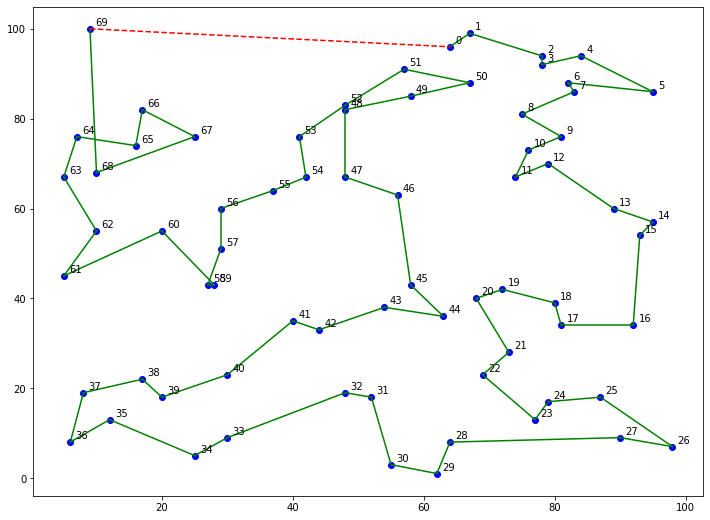

In [478]:
solver = basic_grasp_model()
print("\nRunning Basic GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

## Side bar: script excluding local search

**This should confirm that semi-greedy solutions are suboptimal!**


Running GRASP.

** GRASP OUTPUT ***
best cost:	-1416.0
best solutions:
[ 0 22 15 37 12 69 58 21 68 28 62 14 18 25 27  7  2  6  1 17 41  3 56 23
 30 34 36  9 51  4 59 33 32 20 42 16 11 61 66 55 50 49 64 57 65 35 63 53
 38 24 45 39 60 26 44 40  5 31 43 19 13 29 67  8 47 10 52 54 48 46]


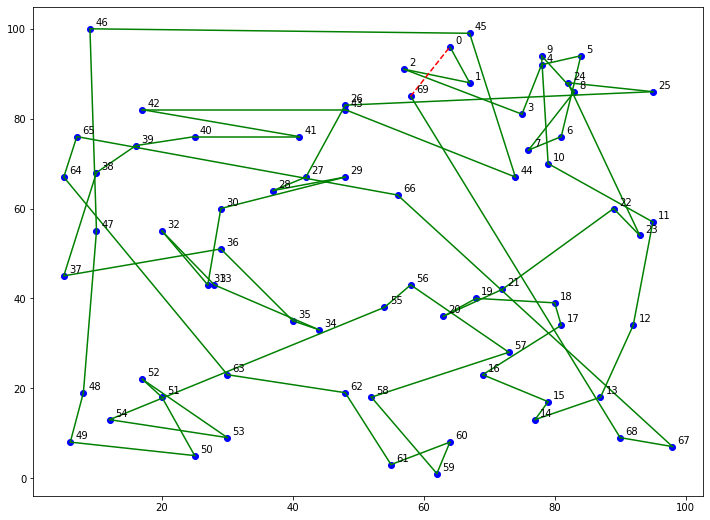

In [15]:
RCL_SIZE = 5

obj = OptimisedSimpleTSPObjective(-matrix)
ls = NullLocalSearch(obj)
# semi-greedy constructor and RCL sizer
sizer = FixedRCLSizer(r=RCL_SIZE)
constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed=None)
solver = GRASP(constructor, ls, max_iter=50)
print("\nRunning GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

## **Variation 1**: Short term memory in the construction phase.

In [16]:
class ConstructorWithMemory:
    '''
    Provides a construction heuristic with a short term memory
    '''
    def __init__(self, constructor, memory_size=100):
        '''Constructor method
        
        Params:
        -------
        constructor: Object
            Implements build() and returns a solution
            
        memory_size, int, optional (default=100)
            size of tabu list
        '''
        self.constructor = constructor
        self.memory_size = memory_size
        # memory implemented as list
        self.history = []
        
    def build(self):
        '''
        Run the stochastic construction heuristic
        
        Re-runs heuristic if results is within memory
        
        Returns:
        --------
        np.ndarray
        '''
        solution = self.constructor.build()
        while str(solution) in self.history:
            solution = self.constructor.build()
        
        # if at capacity remove oldest solution
        if len(self.history) >= self.memory_size: 
            self.history.pop(0)
        
        self.history.append(str(solution))
        return solution

In [475]:
def tabu_list_model(max_iter=50, rcl_size=5, memory_size=100):
    # objective function
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt(random_seed=None)

    # local search = first improvement hill climbing
    ls = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and RCL sizer
    sizer = FixedRCLSizer(r=5)
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed=None)
    # add memory to constructor
    constructor = ConstructorWithMemory(constructor, memory_size=memory_size)

    # bring ingredients together in the GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)
    
    return solver


Running GRASP.

** GRASP OUTPUT ***
best cost:	-748.0
best solutions:
[ 0 15 46 36 57 49 50 64 63 55 10 47 66 53 61 32 59 11 33 20 16 42 43 67
  8 60 38 24 44 39 45 26 29 19 13 27 48 54 25  7  2 31  6 18  1  3 17 41
 40  5 51  9  4 52 65 14 23 56 62 21 58 37 22 35 28 12 30 68 69 34]


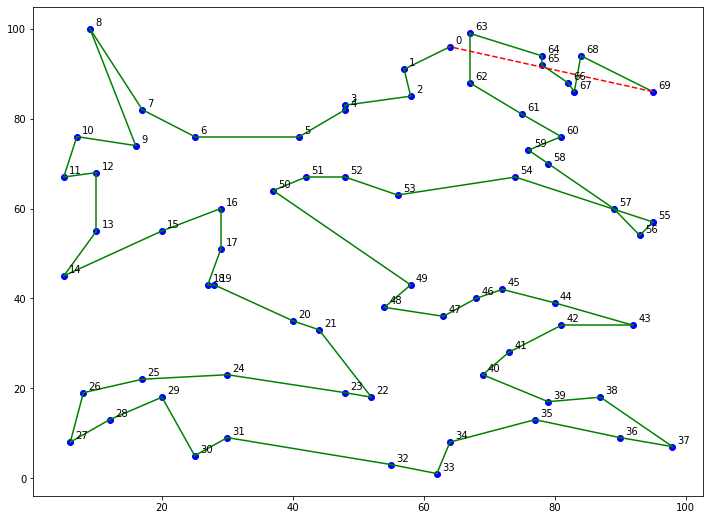

In [476]:
solver = tabu_list_model()
print("\nRunning GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

## Variation 3: **probabilistic selection of RCL size**

In general, the increased exploration from randomly selecting the RCL length should lead to better solutions.  This may be at the cost of slightly increased run time i.e. might be better to run with a `max_iter` than `time_limit` when comparing with a fixed sized RCL.

In [472]:
def prob_rcl_size_model(max_iter=50):
    RCL_MIN = 2
    RCL_MAX = 15

    # objective function
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt(random_seed=None)

    # local search = first improvement hill climbing
    ls = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and RCL sizer
    sizer = RandomRCLSizer(np.arange(RCL_MIN, RCL_MAX), random_seed=None)
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed=None)

    # GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)
    
    return solver


Running Random GRASP.

** GRASP OUTPUT ***
best cost:	-768.0
best solutions:
[ 0 35 28 12 69 30 68 34 56 14 23 18 54 48 25  6  1  3 17 31  2  7 27 13
 19 29 26 45 44 24 38 60 39  8 16 42 67 43 41 40  5 65 62 21 58 37 22 15
 46 36 57 49  4 52  9 51 59 11 20 33 32 61 53 47 66 55 50 10 63 64]


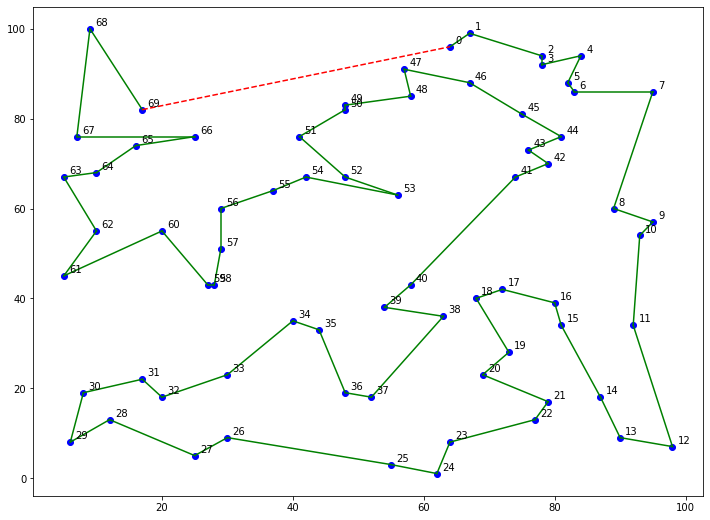

In [473]:
solver = prob_rcl_size_model()
print("\nRunning Random GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

# Reactive GRASP

In reactive GRASP the probability of selecting a RCL size is proportional to historical performance of this RCL size.

Let $q_i = f^* / A_i$
and $p_i = \dfrac{q_i}{\sum_{j=1}^{m} q_j}$
        
where

$f^*$ is the incumbent (best cost); 
$A_i$ is the mean cost found with $r_i$

larger $q_i$ indicates more suitable values of $r_i$

To implement we create two new classes:

* `MonitoredLocalSearch` - wraps HillClimber and notifies observering classes when a GRASP local search phase is complete.
* `ReactiveRCLSizer` - observes GRASP local search, tracks average performance of RCL sizes, and updates prob of choosing different r's at a user specified frequency.

In [19]:
class MonitoredLocalSearch:
    '''
    Extends a local search class and provides the observer pattern.
    An external object can observe the local search object and catch the
    termination event (end of local search).  The observer is notified and
    passed the results of the local search.

    Use cases: 
    ----------
    In GRASP this is useful for an algorithm sizing the RCL and learning 
    on average how different sizes of RCL perform.
    '''
    def __init__(self, local_search):
        '''
        Constructor:
        
        Params:
        ------
        local_search: Object
            Must implement .solve(), best_cost, best_solution
        '''
        self.local_search = local_search
        self.observers = []
    
    def register_observer(self, observer):
        '''
        register an object to observe the local search
        
        The observer should implement 
        local_search_terminated(*args, **kwargs)
        '''
        self.observers.append(observer)
        
    def set_init_solution(self, solution):
        '''
        Set the initial solution
        
        Params:
        --------
        solution: np.ndarray
            vector representing the initial solution
        '''
        self.local_search.set_init_solution(solution)
    
    def solve(self):
        '''
        Run the local search.  
        At the end of the run all observers are notified.
        '''    
        # run local search
        self.local_search.solve()
        
        # notify observers after search terminates.
        best = self.local_search.best_cost
        solution = self.local_search.best_solutions[0]
        self.notify_observers(best, solution)
        
    
    def notify_observers(self, *args, **kwargs):
        '''
        Observers must implement `local_search_terminated()`
        method.
        
        Params:
        ------
        *args: list
            variable number of arguments
            
        **kwargs: dict
            key word arguments
        '''
        for o in self.observers:
            o.local_search_terminated(*args, **kwargs)
    
    def _get_best_cost(self):
        '''
        best cost from internal local_search object
        '''
        return self.local_search.best_cost
    
    def _get_best_solutions(self):
        '''
        get best solutions from local_search object
        '''
        return self.local_search.best_solutions
    
    best_cost = property(_get_best_cost, doc='best cost')
    best_solutions = property(_get_best_solutions, doc='best solution')
        

In [20]:
class ReactiveRCLSizer:
    '''
    Dynamically update the probability of selecting a 
    value of r for the size of the RCL.
    
    Implements Reactive GRASP.
    
    '''
    def __init__(self, r_list, local_search, freq=None, random_seed=None):
        '''
        Constructor
        
        Params:
        -------
        r_list: list
            vector of sizes for RCL e.g. [1, 2, 3, 4, 5]
            
        local_search: MonitoredLocalSearch
            local_search to monitor
            
        freq: int, optional (default=None)
            Frequency in iterations at which the probabilities are updated.
            When set to None it defaults to the length of r_list * 2
            
        random_seed: int, optional (default=None)
            Control random sampling for reproducible result
        '''
        # list of r sizes
        self.r_list = r_list
        
        # set of indexes to work with probabilities
        self.elements = np.arange(len(r_list))
    
        # probability of choosing r (initially uniform)
        self.probs = np.full(len(r_list), 1/len(r_list))
        
        # mean performance of size r
        self.means = np.full(len(r_list), 1.0)
        
        # runs of size r
        self.allocations = np.full(len(r_list), 0)
        
        # local search to monitor
        self.local_search = local_search
        
        # frequency of updating probs
        if freq is None:
            self.freq = len(self.r_list)
        else:
            self.freq = freq
        
        # number of iterations within frequency
        self.iter = 0
        
        # current r index
        self.index = -1
        
        # to init run one of each r value
        self.init = True
        
        # imcumbent solution cost
        self.best_cost = -np.inf
        
        # register sizer as observer of the local search
        local_search.register_observer(self)
        
        # random no. gen
        self.rng = np.random.default_rng(random_seed)
    
    def local_search_terminated(self, *args, **kwargs):
        '''
        Termination of the local search
        '''
        # iteration complete
        self.iter += 1
        
        # get the best cost found in the iteration
        iter_cost = args[0]

        # record iteration took plaxe with index i
        self.allocations[self.index] += 1
        
        # update running mean
        mean_x = self.means[self.index]
        n = self.allocations[self.index]
        self.means[self.index] += (iter_cost - mean_x) / n
        
        self.update_r()
        
        # update incumbent cost if required
        if iter_cost > self.best_cost:
            self.best_cost = iter_cost
        
        # update probs if freq met.
        if self.iter >= self.freq and not self.init:
            self.iter = 0
            self.update_probability()
            
        
    def update_probability(self):
        '''
        Let $q_i = f^* / A_i$
        and $p_i = `\dfrac{q_i}{\sum_{j=1}^{m} q_j}$
        
        where
        
        $f^*$ is the incumbent (cost)
        $A_i$ is the mean cost found with r_i
        
        larger q_i indicates more suitable values of r_i
        '''
        q = self.best_cost / self.means
        self.probs = q / q.sum()
    
    def update_r(self):
        '''
        update the size of r
        
        Note that the implementation ensures that all r values are run
        for at least one iteration of the algorithm.
        '''
        # initial bit of logic makes sure there is at least one run of all probabilities
        if self.init:
            self.index += 1
            if self.index >= len(self.r_list):
                self.init = False
                self.index = self.rng.choice(self.elements, p=self.probs)
        else:
            self.index = self.rng.choice(self.elements, p=self.probs)
    
    def get_size(self):
        '''
        Return the selected size of the RCL
        
        The selection is done using a discrete distribution
        self.r_probs.
        '''
        return self.r_list[self.index]
       

In [468]:
def reactive_grasp_model(max_iter=50, freq=10):
    RCL_MIN = 2
    RCL_MAX = 15

    # objective function
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt(random_seed=None)

    # local search = first improvement hill climbing
    ls = MonitoredLocalSearch(HillClimber(obj, tour, tweaker))

    # semi-greedy constructor and RCL sizer
    sizer = ReactiveRCLSizer(np.arange(RCL_MIN, RCL_MAX), ls, freq=freq, random_seed=None)
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed=None)

    # GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)
    
    return solver


Running REACTIVE GRASP.

** GRASP OUTPUT ***
best cost:	-728.0
best solutions:
[ 0 35 28 12 69 30 68 37 22 15 46 36 57 49 50 55 64 63 10 66 47 53 61 33
 20  8 60 38 24 44 39 45 26 67 43 29 19 13 27 48 54 25  7  2 31  6 18  1
  3 17 41  5 40 42 16 11 32 59 51  9  4 52 65 21 58 62 23 14 56 34]
RCL size allocations: [5 3 4 2 4 3 2 4 4 4 7 4 4]
RCL size means: [-820.4        -830.         -840.25       -826.         -815.5
 -846.33333333 -811.5        -837.5        -816.5        -840.
 -810.57142857 -801.         -838.25      ]


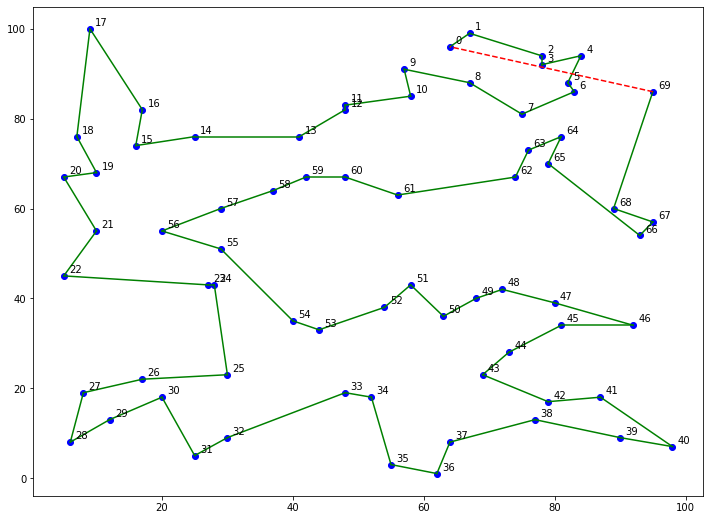

In [471]:
solver = reactive_grasp_model()
print("\nRunning REACTIVE GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
print(f'RCL size allocations: {solver.constructor.rcl_sizer.allocations}')
print(f'RCL size means: {solver.constructor.rcl_sizer.means}')
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

## Variation 4: **Random - Greedy**

This variation modifies the semi-greedy constrction. This now consists of an tunable random phase (where cities are selected at random) and a semi-greedy RCL phase.

In [22]:
class RandomPlusGreedyConstructor(SemiGreedyConstructor):
    '''
    Random + semi-greedy construction of a tour.
    
    The first n cities of a tour are randomly constructed.  
    The remaining cities are seleted using the standard semi-greedy approach.
    
    For a city i creates a restricted candidate list of size r
    i.e the r shortest distances from city i.  Next city is chosen
    with equal probability. 
    
    Repeats until tour is constructed.
    
    '''
    def __init__(self, rcl_sizer, tour, matrix, p_rand=0.2,
                 random_seed=None):
        '''
        RandomPlusGreedy Constructor method
        
        Params:
        ------
        rcl_sizer: object
            sizes the restricted candidate list
        
        tour: np.ndarray
            vector of city indexes included in problem
            
        matrix: np.ndarray
            matrix of travel costs
            
        p_rand: float, optional (default=0.2)
            Proportion of tour that is randomly constructed
            
        random_seed: int
            used to control sampling provides a
            reproducible result.
        '''
        
        # super class init
        super().__init__(rcl_sizer, tour, matrix,
                       random_seed)
        
        # proportion of tour that is randomly constructed
        self.p_rand = p_rand
        self.n_rand = int(p_rand * len(tour))
        self.n_greedy = len(tour) - self.n_rand - 1
        
    
    def build(self):
        '''
        Random followed by semi-greedy contruction of tour
        
        Returns:
        --------
        np.array
        '''
        # first city in tour
        solution = np.array([self.tour[0]])    
        # next n_rand cities are random
        rand = self.rng.choice(self.tour[1:], size=self.n_rand, replace=False)
        solution = np.append(solution, rand)
        
        # remaining cities are semi-greedy
        for i in range(self.n_greedy):
            r = self.rcl_sizer.get_size()
            rcl = self.get_rcl(r, solution, solution[-1])
            next_city = self.random_from_rcl(rcl)
            solution = np.append(solution, np.array([next_city]))
            
        return solution        

In [463]:
def random_greedy_model(max_iter=50):
    # objective function; optimised = numpy
    # not this calculates cost of full tour
    # doesn't consider gain or hash solution:cost to increase efficiency
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt(random_seed=None)

    # local search = first improvement hill climbing
    ls = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and RCL sizer
    sizer = FixedRCLSizer(r=5)
    constructor = RandomPlusGreedyConstructor(sizer, tour, -matrix, p_rand=0.2, 
                                              random_seed=None)

    # bring ingredients together in the GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)

    return solver


Running Random Plus Greedy GRASP.

** GRASP OUTPUT ***
best cost:	-745.0
best solutions:
[ 0 15 46 36 57 49 50 55 64 63 10 47 66 53 61 33 20 11 32 59 51  9  4 52
  5 40 42 16  8 39 60 38 24 44 45 26 29 19 13 27 48 54 25  7  2 43 67 41
 17  3 31  6  1 18 23 14 56 62 65 21 58 37 68 30 69 28 12 22 35 34]


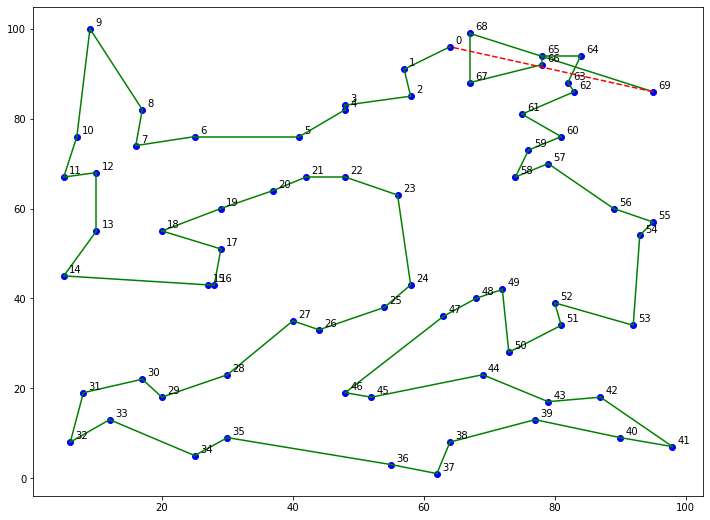

In [464]:
solver = random_greedy_model()
print("\nRunning Random Plus Greedy GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

## **Pick and mix**

In [466]:
def pick_n_mix_model(max_iter=50):
    RCL_MIN = 2
    RCL_MAX = 15

    # objective function
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt(random_seed=None)

    # local search = first improvement hill climbing
    ls = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and Random RCL sizer
    sizer = RandomRCLSizer(np.arange(RCL_MIN, RCL_MAX), random_seed=None)
    constructor = RandomPlusGreedyConstructor(sizer, tour, -matrix, p_rand=0.2, 
                                              random_seed=None)
    # add memory to constructor
    constructor = ConstructorWithMemory(constructor)

    # GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)
    
    return solver


Running Pick and Mix GRASP.

** GRASP OUTPUT ***
best cost:	-727.0
best solutions:
[ 0 35 22 12 28 69 34 30 68 37 58 21 65 62 56 14 23 18 54 48 25  7 27  2
 31  6  1  3 17 41  5 40 42 16 67 43 13 19 29 26 45 24 44 38 60 39  8 33
 20 11  4 52 46 36 57 49  9 51 59 32 61 53 66 47 10 63 64 55 50 15]


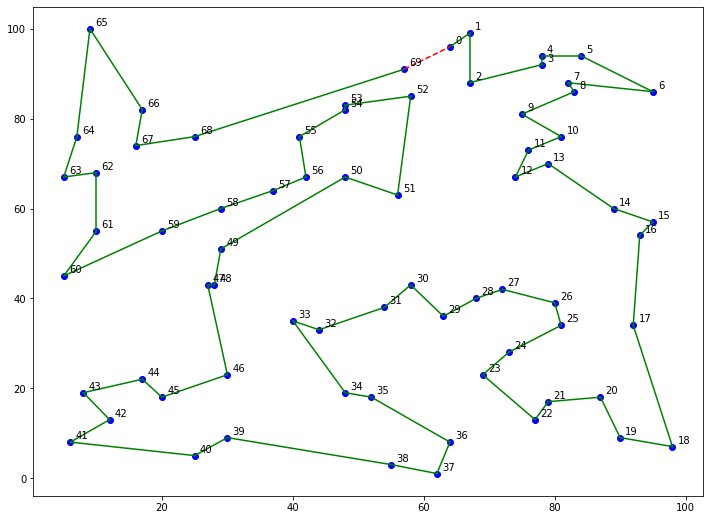

In [467]:
solver = pick_n_mix_model()
print("\nRunning Pick and Mix GRASP.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

## **Elite Sets**

> These are just notes on how to create a TSP type elite set based on differences in tour and better performance than the worst case. But actually I think this would work similar if problem were binary integer.  For a set covering problem then would need to look at a tweaked implementation looking at symmetric differences between sets.

In [199]:
def update_elite_set(s, s_cost, elite_set=None, elite_costs=None, max_size=2, 
                     min_delta=0):
    '''
    Function to illustrate updating an elite set to maximise
    performance and diversity
    
    Params:
    -------
    s: np.ndarray
        TSP tour
        
    s_cost: float
        TSP tour cost
        
    elite_set: np.ndarray
        matrix of tours in elite set 
        
    elite_costs: np.ndarray
        vector of costs associate with each tour in elite set
        
    max_size:
        maximum entries in the elite set
        
    min_delta: int, optional (Default=0)
        The min cardinality difference between tours to allow entry
        E.g. a = [1, 2, 3, 4, 5]; b = [1, 3, 4, 2, 5]. delta = 3.
        Vary delta > 0 to increase diversity (but mauy limit entry)
        
    Returns:
    -------
    Tuple: np.ndarray, np.ndarray
        elite_set, elite_costs
        
    
    Example usage:
    --------------
    ```python
    >>  x = np.array([1, 2, 3, 4, 6, 7, 8])
    >> y = np.array([1, 4, 2, 6, 7, 3, 8])
    >> z = np.array([1, 5, 2, 6, 8, 3, 7])

    >> elite_set, elite_costs = update_elite_set(x, 10)
    >> elite_set, elite_costs = update_elite_set(y, 20, elite_set, elite_costs, max_size=2)
    >> print(elite_set)
    
    [[1 2 3 4 6 7 8]
     [1 4 2 6 7 3 8]]

    >> elite_set, elite_costs = update_elite_set(z, 15, elite_set, elite_costs, max_size=2)
    >> print(elite_set)
    
    [[1 5 2 6 8 3 7]
     [1 4 2 6 7 3 8]]
    ```
    '''
    
    if elite_set is None:
        # initalise elite_set
        elite_set = np.array([s])
        elite_costs = np.array([s_cost])
        return elite_set, elite_costs
        
    elif len(elite_set) < max_size:
        delta = (s != elite_set).sum(axis=1).min()
        if delta > min_delta:
            elite_set = np.append(elite_set, [s], axis=0)
            elite_costs = np.append(elite_costs, [s_cost], axis=0)
    else:
        # aim to increase performance and diversity of elite set
        worst_cost = elite_costs.min()
        delta = (s != elite_set).sum(axis=1).min()
        
        if s_cost > worst_cost and delta > min_delta:
            replace_idx = elite_costs.argmin()
            elite_set[replace_idx] = s
            elite_costs[replace_idx] = s_cost
            
    return elite_set, elite_costs

In [200]:
# example script
x = np.array([1, 2, 3, 4, 6, 7, 8])
y = np.array([1, 4, 2, 6, 7, 3, 8])
z = np.array([1, 5, 2, 6, 8, 3, 7])

elite_set, elite_costs = update_elite_set(x, 10)
elite_set, elite_costs = update_elite_set(y, 20, elite_set, elite_costs, max_size=2)
print(elite_set)

elite_set, elite_costs = update_elite_set(z, 15, elite_set, elite_costs, max_size=2)
print(elite_set)

[[1 2 3 4 6 7 8]
 [1 4 2 6 7 3 8]]
[[1 2 3 4 6 7 8]
 [1 4 2 6 7 3 8]]


## Path Relinking

### Making a single restricted neighbourhood move.

> The functions below provide basic logic for a single move in a path relinking neighbourhood.

In [27]:
def evaluate_neighbour(from_city, current, guiding, obj):
    '''
    Performs a two city swap and returns the cost.
    '''
    from_index = np.where(current==from_city)[0][0]
    to_index = np.where(guiding==from_city)[0][0]
    # swap and evaluate
    current[from_index], current[to_index] = current[to_index], current[from_index]
    cost= obj.evaluate(current)
    print(current, cost)
    
    #swap back
    current[from_index], current[to_index] = current[to_index], current[from_index]
    return cost


In [350]:
#the code below defines a single step

def next_restricted_neighbour_move(current, guiding, obj):
    '''
    Selects the next move to make in a restricted neighbourhood 
    '''
    # cities in the restricted neighbourhood
    swaps = current[current != guiding]
    costs = np.full(len(swaps), -np.inf)
    i = 0
    # is there a way to eliminate the python loop?
    for from_city in swaps:
        # evaluate all swaps in current restricted neighbourhood
        print(f'move {i+1} ', end='=> ')
        costs[i] = evaluate_neighbour(from_city, current, guiding, obj)
        i += 1

    best_index = np.argmax(costs)
    from_city = swaps[best_index]
    
    # get index of cities in current and guiding solutions.
    from_idx = np.where(current==from_city)[0][0]
    to_idx = np.where(guiding==from_city)[0][0]
    # swap and evaluate
    current[from_idx], current[to_idx] = current[to_idx], current[from_idx]
    return current, costs[best_index]

In [351]:
# script for single neighbour move
obj = OptimisedSimpleTSPObjective(-matrix)
current = np.array([1, 2, 3, 4, 5])
guiding = np.array([1, 3, 5, 2, 4])
step, cost = next_restricted_neighbour_move(current.copy(), guiding, obj)
print(f'solution after one step {step}: {cost}')

[2 3 4 5]
move 1 => [1 4 3 2 5] -142.0
move 2 => [1 3 2 4 5] -125.0
move 3 => [1 2 3 5 4] -121.0
move 4 => [1 2 5 4 3] -112.0
solution after one step [1 2 5 4 3]: -112.0


In [30]:
step, cost = next_restricted_neighbour_move(step.copy(), guiding, obj)
print(f'solution after two steps {step}: {cost}')

move 1 => [1 4 5 2 3] -120.0
move 2 => [1 2 5 3 4] -134.0
move 3 => [1 3 5 4 2] -117.0
solution after two steps [1 3 5 4 2]: -117.0


In [31]:
# only one move remaining actually...
step, cost = next_restricted_neighbour_move(step.copy(), guiding, obj)
print(f'solution after three steps is the guiding! {step}: {cost}')

move 1 => [1 3 5 2 4] -138.0
move 2 => [1 3 5 2 4] -138.0
solution after three steps is the guiding! [1 3 5 2 4]: -138.0


In [32]:
def path_relinking(current, guiding, obj, trunc=None):
    '''
    path relinking for basic symmetric TSP.
    
    Although I think that backward will work similar.
    Just swap the current and guiding parameters when calling the func.
    '''
    # moves to relink = n - 1: note we don't need to make the final one i.e n-2
    n_moves = len(current[current != guiding]) - 2
    
    # used to truncate path relinking
    if trunc is not None:
        if trunc > n_moves:
            raise ValueError(f'@trunc must be <= moves to relink{n_moves}')
        else:
            n_moves = trunc
        
    costs = []
    solutions = []
    for i in range(n_moves):
        print(f'#### MOVE {i}')
        current, cost = next_restricted_neighbour_move(current.copy(), guiding, 
                                                       obj)
        print(f'**Selected: {current}')
        solutions.append(current)
        costs.append(cost)
    
    # return best solution and cost
    best_idx = np.array(costs).argmax()
    return solutions[best_idx], costs[best_idx]

In [34]:
# script for forward path relinking
obj = OptimisedSimpleTSPObjective(-matrix)
current = np.array([1, 2, 3, 4, 5])
guiding = np.array([1, 3, 5, 2, 4])
solution, cost = path_relinking(current.copy(), guiding, obj)
print(f'solution after forward PR {solution}: {cost}')

#### MOVE 0
move 1 => [1 4 3 2 5] -142.0
move 2 => [1 3 2 4 5] -125.0
move 3 => [1 2 3 5 4] -121.0
move 4 => [1 2 5 4 3] -112.0
**Selected: [1 2 5 4 3]
#### MOVE 1
move 1 => [1 4 5 2 3] -120.0
move 2 => [1 2 5 3 4] -134.0
move 3 => [1 3 5 4 2] -117.0
**Selected: [1 3 5 4 2]
solution after forward PR [1 2 5 4 3]: -112.0


In [35]:
# script for backward path relinking
obj = OptimisedSimpleTSPObjective(-matrix)
current = np.array([1, 2, 3, 4, 5])
guiding = np.array([1, 3, 5, 2, 4])
solution, cost = path_relinking(guiding.copy(), current, obj)
print(f'solution after backward PR {solution}: {cost}')

#### MOVE 0
move 1 => [1 5 3 2 4] -147.0
move 2 => [1 3 4 2 5] -138.0
move 3 => [1 2 5 3 4] -134.0
move 4 => [1 3 5 4 2] -117.0
**Selected: [1 3 5 4 2]
#### MOVE 1
move 1 => [1 5 3 4 2] -139.0
move 2 => [1 3 2 4 5] -125.0
move 3 => [1 2 5 4 3] -112.0
**Selected: [1 2 5 4 3]
solution after backward PR [1 2 5 4 3]: -112.0


In [36]:
# script for backward path relinking - truncated at 1 move.
obj = OptimisedSimpleTSPObjective(-matrix)
current = np.array([1, 2, 3, 4, 5])
guiding = np.array([1, 3, 5, 2, 4])
solution, cost = path_relinking(guiding.copy(), current, obj, trunc=1)
print(f'solution after backward PR {solution}: {cost}')

#### MOVE 0
move 1 => [1 5 3 2 4] -147.0
move 2 => [1 3 4 2 5] -138.0
move 3 => [1 2 5 3 4] -134.0
move 4 => [1 3 5 4 2] -117.0
**Selected: [1 3 5 4 2]
solution after backward PR [1 3 5 4 2]: -117.0


## GRASP with Path Relinking

We can take the concepts of GRASP, elite sets and path relinking and combine them.

* The first class `EliteSet` which, if required, track the a `GRASP` objects `MonitoredLocalSearch` and update the an elite set after each iteration.
* `TSPPathRelinker` implements forward or backward path relinking logic with the option to truncate the relinking after a fixed number of moves.
* `GRASPPlusPathRelinking` is an modification of the basic `GRASP` and adds path relinking plus an update of the elite set after each iteration.

In [329]:
class EliteSet:
    '''
    Tracks and updates an elite set of solutions produced by a local search.
    '''
    def __init__(self, local_search=None, max_size=10, min_delta=0):
        '''
        Constructor
        Params:
        -------
        local_search: MonitoredLocalSearch
            The local search that produces candidates for the elite
            set.
        
        max_size: int, optional (default=10)
            maximum entries in the elite set

        min_delta: int, optional (Default=0)
            The min cardinality difference between tours to allow entry
            E.g. a = [1, 2, 3, 4, 5]; b = [1, 3, 4, 2, 5]. delta = 3.
            Vary delta > 0 to increase diversity (but may limit entry)
        '''
        if local_search is not None:
            self.local_search = local_search
            local_search.register_observer(self)
        
        self.min_delta = min_delta
        self.max_size = max_size
        
        # data structures for elite solutions
        self.solutions = None
        self.costs = None
        
        self.n_updates = 0
    
    @property
    def is_empty(self):
        return self.solutions is None
    
    def is_elite(self, solution):
        '''
        Is the solution a member of the elite set
        
        Params:
        ------
        solution: np.ndarray
            TSP solutution
            
        Returns:
        --------
        bool
        '''
        if self.solutions is None:
            return False
        else:
            result = np.where((self.solutions==solution).all(axis=1))[0]
            return len(result) > 0
    
    def local_search_terminated(self, *args, **kwargs):
        ''''
        Termination of the local search
        '''
        s = args[1]
        s_cost = args[0]
        self.update(s, s_cost)
            
    def init_elite_set(self, s, s_cost):
        '''
        Initalise the elite set
        '''
        self.solutions = np.array([s])
        self.costs = np.array([s_cost])
    
    def update(self, s, s_cost):
        '''
        Update the elite set to maximise performance and diversity

        Params:
        -------
        s: np.ndarray
            TSP tour

        s_cost: float
            TSP tour cost

        Returns:
        -------
        Tuple: np.ndarray, np.ndarray
            elite_set, elite_costs
        '''
        if self.solutions is None:
            self.init_elite_set(s, s_cost)
        
        elif len(self.solutions) < self.max_size:
            delta = (s != self.solutions).sum(axis=1).min()
            if delta > self.min_delta:
                self.solutions = np.append(self.solutions, [s], axis=0)
                self.costs = np.append(self.costs, [s_cost], axis=0)
        else:
            # aim to increase performance and diversity of elite set
            worst_cost = self.costs.min()
            delta = (s != self.solutions).sum(axis=1).min()

            if s_cost > worst_cost and delta > self.min_delta:
                replace_idx = self.costs.argmin()
                self.solutions[replace_idx] = s
                self.costs[replace_idx] = s_cost
                self.n_updates += 1
                
    def get_best_solution(self):
        '''Returns the best solution and cost
        from the elite set'''
        best_idx = np.array(self.costs).argmax()
        return self.solutions[best_idx], self.costs[best_idx]

## script to test tracking an elite set


Running GRASP with Elite Set Tracking.

** GRASP OUTPUT ***
best cost:	-735.0
Elite set costs: [-752. -777. -775. -739. -791. -796. -743. -788. -735. -741.]
best solution:
[ 0 15 46 22 12 28 69 30 68 34 58 37 21 65 62 56 14 23 18 54 48 25  7 27
 13 19 29  2 31  6  1  3 17 41  5 40 16 42 43 67  8 26 45 39 44 24 38 60
 61 53 32 33 20 11 59 51  9  4 52 36 57 49 50 55 66 47 10 63 64 35]


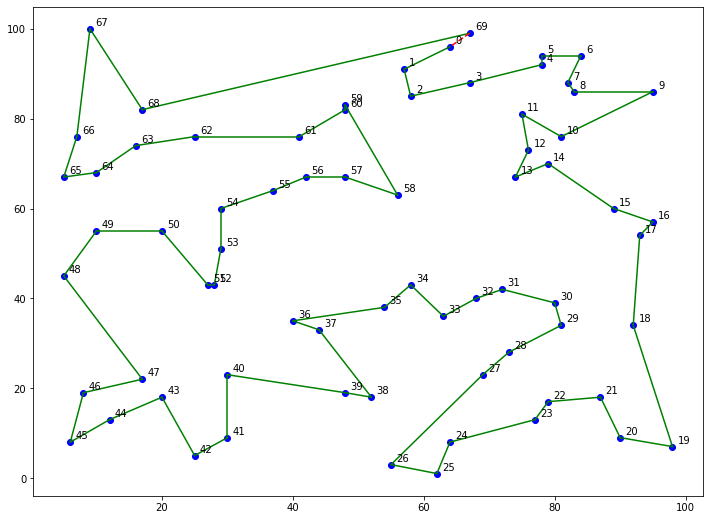

In [330]:
RCL_MIN = 2
RCL_MAX = 15

# objective function
obj = OptimisedSimpleTSPObjective(-matrix)

# Two-opt tweaks
tweaker = TweakTwoOpt(random_seed=None)

# local search = first improvement hill climbing
ls = MonitoredLocalSearch(HillClimber(obj, tour, tweaker))

# semi-greedy constructor and RCL sizer
sizer = RandomRCLSizer(np.arange(RCL_MIN, RCL_MAX), random_seed=None)
constructor = SemiGreedyConstructor(sizer, tour, -matrix, random_seed=None)

# elite set tracker
tracker = EliteSet(ls)

# GRASP framework
solver = GRASP(constructor, ls, max_iter=50)

print("\nRunning GRASP with Elite Set Tracking.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print(f'Elite set costs: {tracker.costs}')

print("best solution:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

In [358]:
x = [1, 2, 3, 4]
x[:-1]

[1, 2, 3]

The next class is a PathRelinking class.  This encapsulates the logic of PR.

In [396]:
class TSPPathRelinker:
    '''
    Path relinking for basic symmetric TSP.
    
    Performs forward or backward relinking with a random
    elite solution from the elite set of from 
    '''
    def __init__(self, local_search, tracker, objective, 
                 trunc=None, random_seed=None):
        
        self.local_search = local_search
        self.tracker = tracker
        self.obj = objective
        self.trunc = trunc
        
        # used for selecting from the elite set at random
        self.rng = np.random.default_rng(random_seed)
        
        self.calls = 0
        self.made_it = 0
        self.already_elite = 0
    
    def evaluate_neighbour(self, from_city, current, guiding):
        '''
        Performs a two city swap and returns the cost.
        '''
        from_idx = np.where(current==from_city)[0][0]
        to_idx = np.where(guiding==from_city)[0][0]
        # swap and evaluate
        current[from_idx], current[to_idx] = current[to_idx], current[from_idx]
        cost= self.obj.evaluate(current)

        #swap back
        current[from_idx], current[to_idx] = current[to_idx], current[from_idx]
        return cost
    
    def next_restricted_neighbour_move(self, current, guiding):
        '''
        Selects the next move to make in a restricted neighbourhood 
        '''
        # cities in the restricted neighbourhood
        
        
        
        swaps = current[current != guiding]
        
        #print('swaps')
        ##print(swaps)
        #print('done')
        
        costs = np.full(len(swaps), -np.inf)
        i = 0
        # is there a way to eliminate the python loop?
        for from_city in swaps:
            # evaluate all swaps in current restricted neighbourhood
            costs[i] = self.evaluate_neighbour(from_city, current, guiding)
            i += 1

        best_index = np.argmax(costs)
        from_city = swaps[best_index]

        # get index of cities in current and guiding solutions.
        from_idx = np.where(current==from_city)[0][0]
        to_idx = np.where(guiding==from_city)[0][0]
        # swap and evaluate
        current[from_idx], current[to_idx] = current[to_idx], current[from_idx]
        return current, costs[best_index]
    
    def relink(self, solution, elite_solution=None, direction='backward'):
        '''
        Relink between a current and guiding solution
        
        Although I think that backward will work similar.
        Just swap the current and guiding parameters when calling the func.
        
        Params:
        -------
        solution: np.ndarray
            a none elite set TSP solution
            
        elite_solution: np.ndarray.
            guiding TSP solution
            
        direction: str
             forward: move from current towards guiding
             backward: swap current and guiding and relink.
        '''
        
        self.calls += 1
        # catch local optimum solutions that are already elite
        if self.tracker.is_elite(solution):
            self.already_elite += 1
            return solution, self.obj.evaluate(solution)
        
        self.made_it += 1
        # random elite solution if none specified
        if elite_solution is None:
            elite_solution = self.rng.choice(self.tracker.solutions)
        
        # if 'forward' selected.
        if direction == 'forward':
            current, guiding = solution, elite_solution
        elif direction == 'backward':
            current, guiding = elite_solution, solution
        else:
            raise ValueError('Please select backward of forward relinking')
        
        # moves to relink n / 2
        n_moves = len(current[current != guiding]) // 2

        # used to truncate path relinking
        if self.trunc is not None:
            if self.trunc > n_moves:
                raise ValueError(f'@trunc must be <= moves to relink {n_moves}')
            else:
                n_moves = self.trunc

        # path relinking
        costs = [self.obj.evaluate(solution)]
        solutions = [solution]
        for i in range(n_moves):
            current, cost = self.next_restricted_neighbour_move(current.copy(), guiding)
            solutions.append(current)
            costs.append(cost)

        # best solution and cost
        # error here if the relinking has found no improvements.
        best_idx = np.array(costs).argmax()
        pr_solution, pr_cost =  solutions[best_idx], costs[best_idx]
        
        # local search on relinked solution...
        self.local_search.set_init_solution(pr_solution)
        self.local_search.solve()
        
        # return local optimum
        return self.local_search.best_solutions[0], self.local_search.best_cost

In [372]:
class GRASPPlusPathRelinking:
    '''
    Greedy Randomised Adaptive Search Procedure algorithm
    hybridised with Path Relinking
    for the Travelling Salesman Problem
    
    '''
    def __init__(self, constructor, local_search, relinker,
                 tracker, max_iter=1000, time_limit=np.inf):
        
        # semi greedy tour construction method
        self.constructor = constructor
        
        # local search procedure
        self.local_search = local_search
        
        # path relinker
        self.path_relinker = relinker
        
        # elite solution tracker
        self.elite_tracker = tracker
        
        # max runtime budget for GRASP
        self.max_iter = max_iter
        self.time_limit = time_limit
        
        # init solution 
        self.best_solution = None
        self.best = None
    
        
    def solve(self):
        '''
        Run GRASP
        
        Returns:
        -------
        None
        '''
        self.best_solution = None
        self.best = -np.inf
        
        i = 0
        start = time.time()
        while i < self.max_iter and ((time.time() - start) < self.time_limit): 
            i += 1
            
            # construction phase
            solution = self.constructor.build()
            
            # Improve solution via local search
            self.local_search.set_init_solution(solution)
            self.local_search.solve()
            
            current_solution = self.local_search.best_solutions[0]
            current_cost = self.local_search.best_cost
            
            if not self.elite_tracker.is_empty:
                # backwards path relinking with elite solution selected at random
                current_solution, current_cost = self.path_relinker.relink(current_solution)
            
            # added because in theory best solution might not go into Elite set due to diversity
            if current_cost > self.best:
                self.best = current_cost
                self.best_solution = current_solution
            
            # update elite solutions
            self.elite_tracker.update(current_solution, current_cost)

In [459]:
def pr_model(max_iter=50, elite_set_size=10):
    RCL_MIN = 2
    RCL_MAX = 15

    # objective function
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt(random_seed=None)

    # local search for main GRASP = first improvement hill climbing
    ls1 = MonitoredLocalSearch(HillClimber(obj, tour, tweaker))

    # local search for path relinking = first improvement hill climbing
    ls2 = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and RCL sizer
    sizer = ReactiveRCLSizer(np.arange(RCL_MIN, RCL_MAX), ls, freq=10, 
                             random_seed=None)
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, 
                                        random_seed=None)

    # elite set tracker
    tracker = EliteSet(min_delta=1, max_size=elite_set_size)

    # path relinking logic
    relinker = TSPPathRelinker(ls2, tracker, obj, trunc=10)

    # GRASP + PR framework
    solver = GRASPPlusPathRelinking(constructor, ls1, relinker, tracker, 
                                    max_iter=max_iter)
    
    return solver


Running GRASP with Path Relinking

** GRASP OUTPUT ***
best cost:	-729.0
Elite set costs: [-733. -745. -740. -741. -729. -742. -741. -737. -739. -733.]
best solution:
[ 0 35 28 69 34 68 30 12 22 15 46 36 57 49 59 51  9  4 52 37 58 62 21 65
 56 14 23 18  6  1  3 17  5 40 41 31  2  7 25 54 48 27 13 19 29 43 67 26
 45 44 24 38 60 39  8 42 16 20 33 11 32 61 53 47 66 10 55 50 64 63]


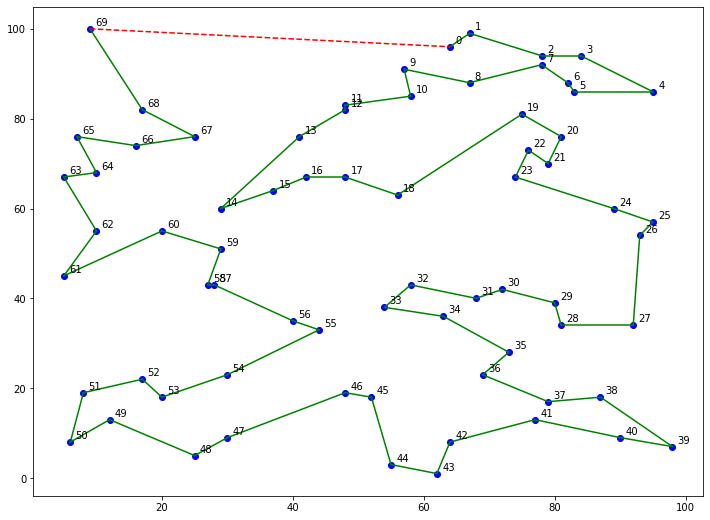

In [461]:
solver = pr_model()
print("\nRunning GRASP with Path Relinking")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print(f'Elite set costs: {solver.elite_tracker.costs}')

print("best solution:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

In [386]:
class EvolutionaryPathRelinker:
    def __init__(self, tracker, relinker):
        self.tracker = tracker
        self.relinker = relinker
        self.best = None
        self.best_solution = None
    
    def relink(self, best_solution, best_cost):
        self.best = best_cost
        self.best_solution = best_solution
        pairwise = self.generate_pairwise_combinations()
        
        for s1, s2 in pairwise:
            new_s, new_cost = self.relinker.relink(s1, s2)
            # update elite set
            self.tracker.update(new_s, new_cost)
            
            if new_cost > self.best:
                self.best = new_cost
                self.best_solution = new_s
            
        elite_solution, elite_best = self.tracker.get_best_solution()
        
        if elite_best > self.best:
            print('Evo PR found a better better solution')
            self.best = elite_best
            self.best_solution = elite_solution
        
    def generate_pairwise_combinations(self):
        return [c for c in combinations(self.tracker.solutions, 2)]

In [456]:
class GRASPPlusEvoPathRelinking(GRASPPlusPathRelinking):
    '''
    Evolutionary path relinking as post processing step.
    '''
    def __init__(self, constructor, local_search, relinker,
                 elite_tracker, max_iter=1000, time_limit=np.inf):
        '''
        Constructor
        
        Params:
        ------
        '''

        super().__init__(constructor, local_search, relinker,
                         elite_tracker, max_iter, time_limit)
        
        self.evo_relinker = EvolutionaryPathRelinker(elite_tracker, relinker)
        self.tracker = tracker
        self.best = None
        self.best_solution = None
        
    def solve(self):
        # run GRASP with path relinking
        super().solve()
        
        self.n_updates_before_evo = self.elite_tracker.n_updates
        self.elite_tracker.n_updates = 0
        print('GRASP complete => running evolutionary path relinking')
        # run evolutionary path relinking
        self.evo_relinker.relink(self.best_solution, self.best)
        
        self.best_solution, self.best = self.elite_tracker.get_best_solution()

In [457]:
def evo_pr_model(max_iter=50, elite_set_size=10, pr_trunc=10):
    '''
    Create a GRASP with EVO path relinking algorithm.
    '''
    RCL_MIN = 2
    RCL_MAX = 15

    # objective function
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt()

    # local search for main GRASP = first improvement hill climbing
    ls1 = MonitoredLocalSearch(HillClimber(obj, tour, tweaker))

    # local search for path relinking = first improvement hill climbing
    ls2 = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and RCL sizer
    sizer = ReactiveRCLSizer(np.arange(RCL_MIN, RCL_MAX), ls, freq=10, 
                             random_seed=None)
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, 
                                        random_seed=None)

    # elite set tracker
    tracker = EliteSet(min_delta=4, max_size=elite_set_size)

    # path relinking logic
    relinker = TSPPathRelinker(ls2, tracker, obj, trunc=pr_trunc)

    # GRASP + EVO PR framework
    solver = GRASPPlusEvoPathRelinking(constructor, ls1, relinker, tracker, 
                                       max_iter=max_iter)
    
    return solver


Running Reactive GRASP with Evo Path Relinking
GRASP complete => running evolutionary path relinking

** GRASP OUTPUT ***
best cost:	-738.0
Elite set costs: [-775. -773. -797. -754. -750. -773. -749. -766. -766. -752.]
N updates to elite set before EvoPR 5
N updates to elite set with EvoPR: 0
best solution:
[ 0 35 15 46 36 57 49  4 52  9 51 59 32 55 50 64 63 10 66 47 53 61 11 33
 20  8 39 60 38 44 24 45 26 67 43 42 16 40  5 41 17  3  6 31  2 29 19 13
 27  7 48 54 25 18  1 23 14 56 62 65 21 37 22 12 28 69 30 68 34 58]


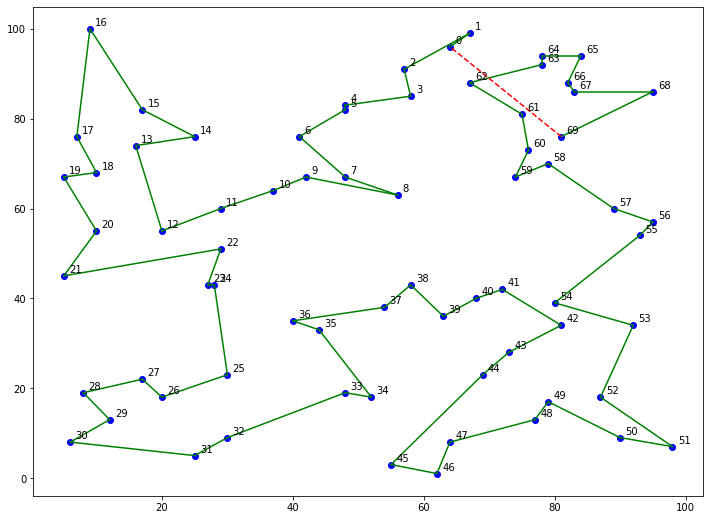

In [458]:
solver = evo_pr_model()
print("\nRunning Reactive GRASP with Evo Path Relinking")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print(f'Elite set costs: {tracker.costs}')
print(f'N updates to elite set before EvoPR {solver.n_updates_before_evo}')
print(f'N updates to elite set with EvoPR: {solver.elite_tracker.n_updates}')

print("best solution:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

# Experiments

Run each of the variations of grasp 10 times with a `MAX_ITER` budget and compare distribution of results.  This is included as a crude form of validation to check the algorithms are performing roughly as expected.

In [509]:
MAX_ITER = 200

In [488]:
def single_run(solver):
    '''
    Run the solver and return the best cost found.
    '''
    solver.solve()
    return solver.best

In [490]:
def experiment1(reps=10, n_jobs=-1):
    '''
    Basic grasp
    '''
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(basic_grasp_model(MAX_ITER)) 
                                  for _ in range(reps))
    return res

In [491]:
def experiment2(reps=10, n_jobs=-1):
    '''
    GRASP with construction tabu list
    '''
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(tabu_list_model(MAX_ITER)) 
                                  for _ in range(reps))
    return res

In [492]:
def experiment3(reps=10, n_jobs=-1):
    '''
    GRASP with probablistic selction of RCL size
    '''
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(prob_rcl_size_model(MAX_ITER))
                                  for _ in range(reps))
    return res

In [493]:
def experiment4(reps=10, n_jobs=-1):
    '''
    Reactive GRASP
    '''
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(reactive_grasp_model(MAX_ITER)) 
                                  for _ in range(reps))
    return res

In [494]:
def experiment5(reps=10, n_jobs=-1):
    '''
    Reactive GRASP + Path Relinking
    '''
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(pr_model(MAX_ITER)) 
                                  for _ in range(reps))
    return res

In [495]:
def experiment6(reps=10, n_jobs=-1):
    '''
    GRASP + Evolutionary Path Relinking
    '''
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(evo_pr_model(MAX_ITER)) 
                                  for _ in range(reps))
    return res
    

In [496]:
def get_experiments():
    experiments = {'basic grasp':experiment1,
                   'tabu list':experiment2,
                   'random rcl size':experiment3,
                   'reactive grasp':experiment4,
                   'path relinking':experiment5,
                    'evolutionary PR':experiment6}
    return experiments

In [510]:
experiments = get_experiments()

results = []
for name, experiment in experiments.items():
    print(f'Running: {name};')
    result = experiment()
    results.append(result)
print('experiments complete')    

Running: basic grasp;
Running: tabu list;
Running: random rcl size;
Running: reactive grasp;
Running: path relinking;
Running: evolutionary PR;
experiments complete


In [511]:
df = pd.DataFrame(results).T
df.columns = experiments.keys()
df.describe().round(0)

,basic grasp,tabu list,random rcl size,reactive grasp,path relinking,evolutionary PR
count,10.0,10.0,10.0,10.0,10.0,10.0
mean,-720.0,-724.0,-720.0,-722.0,-691.0,-700.0
std,7.0,10.0,5.0,11.0,10.0,11.0
min,-731.0,-735.0,-731.0,-736.0,-712.0,-718.0
25%,-723.0,-734.0,-721.0,-731.0,-696.0,-706.0
50%,-716.0,-727.0,-719.0,-724.0,-692.0,-702.0
75%,-715.0,-716.0,-716.0,-713.0,-684.0,-695.0
max,-713.0,-709.0,-714.0,-704.0,-677.0,-684.0


In [513]:
df

,basic grasp,tabu list,random rcl size,reactive grasp,path relinking,evolutionary PR
0,-716.0,-735.0,-718.0,-724.0,-683.0,-702.0
1,-731.0,-734.0,-731.0,-725.0,-712.0,-695.0
2,-715.0,-732.0,-714.0,-726.0,-686.0,-685.0
3,-717.0,-709.0,-716.0,-708.0,-696.0,-718.0
4,-713.0,-711.0,-715.0,-736.0,-698.0,-684.0
5,-723.0,-715.0,-727.0,-714.0,-695.0,-709.0
6,-723.0,-732.0,-719.0,-733.0,-677.0,-702.0
7,-731.0,-734.0,-720.0,-704.0,-691.0,-704.0
8,-716.0,-722.0,-719.0,-713.0,-693.0,-707.0
9,-713.0,-720.0,-721.0,-733.0,-680.0,-695.0


# Random good solutions

[ 0 35 28 12 69 34 30 68 37 58 21 65 62 56 14 23 18 54 48 25  7 27  2 31
  6  1  3 17 41  5 40 13 19 29 43 67 26 45 24 44 38 60 39  8 42 16 20 33
 11 32 61 53 47 66 55 10 63 64 50 59 51  9  4 52 49 57 36 46 15 22]


[ 0 15 46 36 57 49 50 55 64 63 10 47 66 53 61 33 20 11 32 59 51  9  4 52
  5 40 42 16  8 60 38 24 44 39 45 26 67 43 29 19 13 27 48 54 25  7  2 31
 41 17  3  1  6 18 23 14 56 62 65 21 58 37 30 68 34 69 28 12 22 35]